# ASL Detection

In [236]:
#import necessary libraries

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, classification_report, accuracy_score, f1_score
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.neural_network import MLPClassifier
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from sklearn.model_selection import cross_val_score
import os
import cv2
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import skimage
from skimage.transform import resize
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve
%matplotlib inline

# Traditional Machine Learning

## Load Data

The data is contained in 29 folders each corresponding to a label: the 26 letters of the English alaphabet, "del," "nothing," and "space." We ommit the non-alphabet data samples for a total of 26 labels. Moreover, the data is split between training and testing sets. Because the provided testing set is very small, we use the provided training set for both training and testing.

In [2]:
#directory of folders
train_dir = r"F:\OneDrive - Cal State LA\Lecture Notes\Spring 2023\Machine Learning 2\ML2 Project\asl_alphabet_train"

classes = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 
           'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 
           'W', 'X', 'Y', 'Z']

The data set includes 3000 samples for each label. Each sample is a 200x200 color image. Because of computational limitations, we both randomly sample the data and decrease the size of the individual images using skimage.transform.resize. We sample an equal number of samples from every label for a balanced dataset.

In [3]:
import random

#specify the number of samples desired for each label
number_of_samples = 500

#create a random sample of ints from 0 to 3000 without repetition
rand_list = random.sample(range(3001), number_of_samples)

#specify desired dimension of the images
imageSize = 50

#create dataframe to serve as feature matrix
X = pd.DataFrame()
y = []

for letter in classes:
    print("loading class:", letter)
    X_temp = []
    for x in rand_list:
        #reads image from directory
        image = mpimg.imread(train_dir + "\\" + letter + "\\"+ letter + str(x) + ".jpg")
        
        #Resize image to imageSize x imageSize pixels
        image = skimage.transform.resize(image, (imageSize, imageSize, 3))
        
        #convert each image into a row of the feature matrix with imageSize * imageSize * 3 columns
        image = image.reshape(imageSize * imageSize * 3)
        
        X_temp.append(image)
        y.append(ord(letter)-65)
        
    X_temp = pd.DataFrame(X_temp)
    X = pd.concat([X, X_temp], axis=0)
    del X_temp

loading class: A
loading class: B
loading class: C
loading class: D
loading class: E
loading class: F
loading class: G
loading class: H
loading class: I
loading class: J
loading class: K
loading class: L
loading class: M
loading class: N
loading class: O
loading class: P
loading class: Q
loading class: R
loading class: S
loading class: T
loading class: U
loading class: V
loading class: W
loading class: X
loading class: Y
loading class: Z


## Data Pre-Processing

In [4]:
X.shape

(13000, 7500)

In [5]:
np.shape(y)

(13000,)

In [6]:
#normalizes each column of the feature matrix using preprocessing.scale
X = preprocessing.scale(X)

In [7]:
#Randomly splits the original dataset into training set and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=5)

#del X

We perform PCA to reduce the dimensionality of our data. By specifiying a desired variance, we can determine the required number of components. We will use this reduced dataset for training our machine learning models.

In [8]:
#Perform PCA to reduce the dimensionality

from  sklearn.decomposition  import  PCA

#specify desired variance
variance = 0.95
my_pca = PCA(n_components = variance)

# X_Train is feature matrix of training set before dimensionality reduction, 
X_train_new = my_pca.fit_transform(X_train)
#del X_train

# X_Train_New is feature matrix of testing set after dimensionality reduction:
X_test_new = my_pca.transform(X_test)
#del X_test

# X_normalized_pca is feature matrix for cross validation grid search after dimensionality reduction:
#X_normalized_pca = my_pca.fit_transform(X)

In [9]:
#determine number of components used:
my_pca.n_components_

80

In [10]:
X_train_new.shape

(9750, 80)

## Model Training

In [11]:
accuracy_scores = {}
precision_scores = {}
recall_scores = {}
f1_scores = {}
AUC_average_scores = {}

## Non-Linear SVM

In [12]:
from sklearn.svm import SVC 

#Instantiates object from the SVM class
my_SVC = SVC(C=1, kernel='rbf', gamma=0.0005, random_state=1)

#Trains SVM Classifier on the training set
my_SVC.fit(X_train_new, y_train)

SVC(C=1, gamma=0.0005, random_state=1)

In [13]:
#Tests SVM Classifier on the testing set
y_predict_SVC = my_SVC.predict(X_test_new)

#Evaluates accuracy of SVM Classifier
score_SVC = accuracy_score(y_test, y_predict_SVC)

print("The accuracy of SVM is:", score_SVC)

The accuracy of SVM is: 0.8455384615384616


## SVC Grid Search

In [14]:
from sklearn.svm import SVC 

#Instantiates object from the SVM class
my_SVC = SVC(probability=True, kernel='rbf',random_state=1)

# # defining parameter range
# param_grid_svc = {'C': [1, 10, 100], 
#                'gamma': [1, 0.01]}  

# defining parameter range
param_grid_svc = {'C': [0.1, 1, 10], 
               'gamma': [1, 0.01, 0.001, 0.0050]}  

#param_grid_svc = {'C': [0.1, 1, 10, 100, 1000], 
#               'gamma': [1, 0.1, 0.01, 0.001, 0.0001, 0.0005],
#               'kernel': ['rbf']} 
  
svc_grid = GridSearchCV(my_SVC, param_grid_svc, cv = 5, scoring='accuracy', verbose = 3)

svc_grid.fit(X_train_new, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5] END ....................C=0.1, gamma=1;, score=0.041 total time=  53.2s
[CV 2/5] END ....................C=0.1, gamma=1;, score=0.040 total time=  55.5s
[CV 3/5] END ....................C=0.1, gamma=1;, score=0.040 total time=  55.5s
[CV 4/5] END ....................C=0.1, gamma=1;, score=0.040 total time=  53.6s
[CV 5/5] END ....................C=0.1, gamma=1;, score=0.040 total time=  55.3s
[CV 1/5] END .................C=0.1, gamma=0.01;, score=0.063 total time=  35.6s
[CV 2/5] END .................C=0.1, gamma=0.01;, score=0.053 total time=  36.6s
[CV 3/5] END .................C=0.1, gamma=0.01;, score=0.056 total time=  36.7s
[CV 4/5] END .................C=0.1, gamma=0.01;, score=0.056 total time=  41.1s
[CV 5/5] END .................C=0.1, gamma=0.01;, score=0.054 total time=  41.6s
[CV 1/5] END ................C=0.1, gamma=0.001;, score=0.314 total time=  31.9s
[CV 2/5] END ................C=0.1, gamma=0.001;

GridSearchCV(cv=5, estimator=SVC(probability=True, random_state=1),
             param_grid={'C': [0.1, 1, 10], 'gamma': [1, 0.01, 0.001, 0.005]},
             scoring='accuracy', verbose=3)

In [15]:
# print best accuracy corresponding to the best structure of model:
print("The best accuracy is:", svc_grid.best_score_)

# print best model paramters 
print("Best parameter value(s):", svc_grid.best_params_)

The best accuracy is: 0.9107692307692308
Best parameter value(s): {'C': 10, 'gamma': 0.001}


In [16]:
best_grid_svc = svc_grid.best_estimator_

y_predict_grid_svc = best_grid_svc.predict(X_test_new)
y_predict_grid_prob_svc = best_grid_svc.predict_proba(X_test_new)

score_grid_svc = accuracy_score(y_test, y_predict_grid_svc)
accuracy_scores["SVM"] = score_grid_svc
precision_scores ["SVM"] = precision_score(y_test, y_predict_grid_svc, average='macro')
recall_scores ["SVM"] = metrics.recall_score(y_test, y_predict_grid_svc, average='macro')
f1_scores ["SVM"] = metrics.f1_score(y_test, y_predict_grid_svc, average='macro')


print("The accuracy of SVC grid is:", score_grid_svc)

The accuracy of SVC grid is: 0.9323076923076923


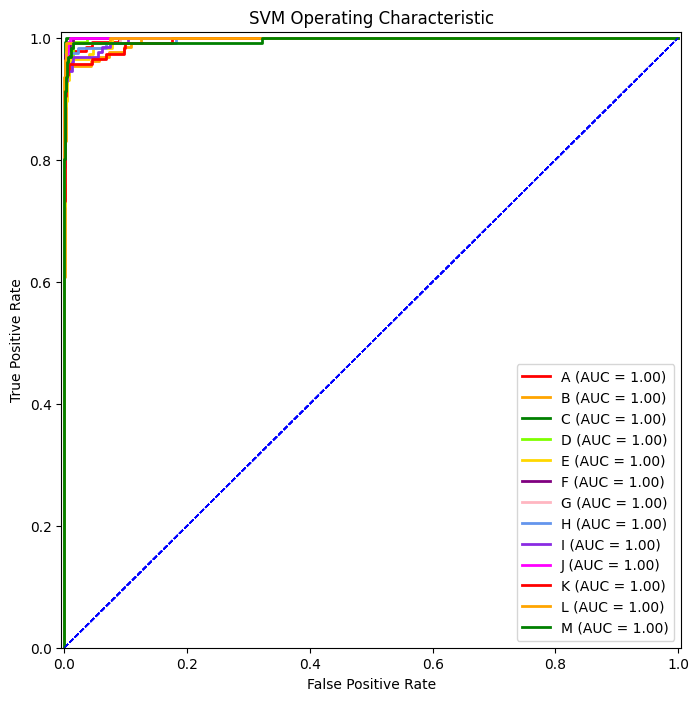

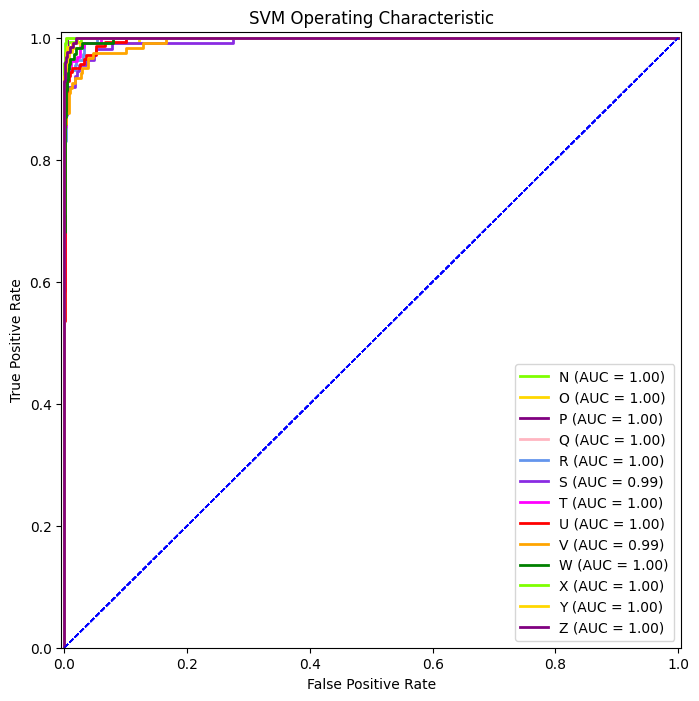

In [17]:
color_list=("red", "orange", "green", "chartreuse", "gold",
            "purple", "lightpink", "cornflowerblue", "blueviolet", "fuchsia")
classes = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 
           'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 
           'W', 'X', 'Y', 'Z']

total_AUC_SVM = 0

plt.figure(figsize=(8,8))

for i in range(len(classes)): 
    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_predict_grid_prob_svc[:,i], pos_label=i)
    

    AUC = metrics.auc(fpr, tpr)
    total_AUC_SVM += AUC
    plt.plot(fpr, tpr, color=color_list[i%10], lw=2, label=  classes[i] + ' (AUC = %0.2f)' % AUC)

    plt.plot([0, 1], [0, 1], color='blue', lw=1, linestyle='--')

    plt.xlim([-0.005, 1.005])
    plt.ylim([0.0, 1.01])

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('SVM Operating Characteristic')
    plt.legend(loc="lower right")

    if i == len(classes)/2 - 1:
      plt.show()
      plt.figure(figsize=(8,8))
        
AUC_average_scores["SVM"] = total_AUC_SVM / 26

In [18]:
print("The average AUC for SVM is:", total_AUC_SVM / 26)

The average AUC for SVM is: 0.9981337566914827


## SVM Confusion Matrix

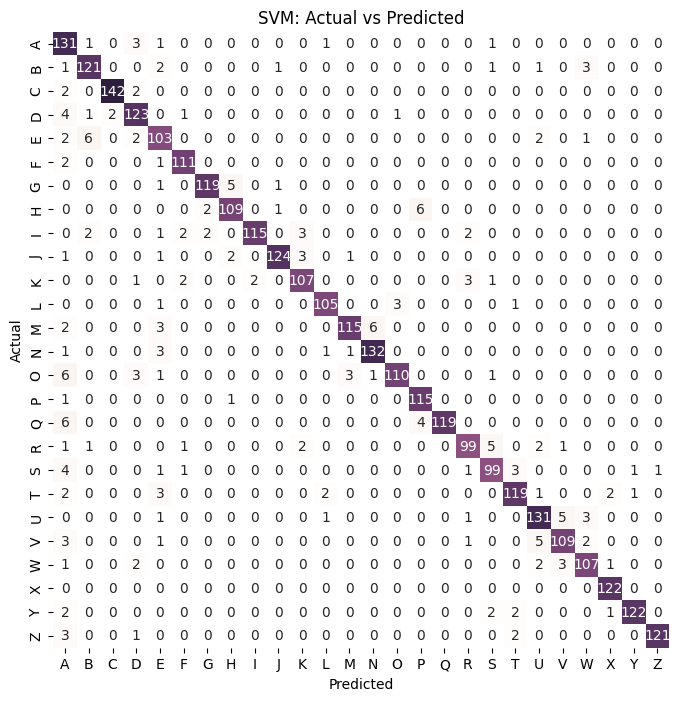

In [19]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


data = confusion_matrix(y_test, y_predict_grid_svc)
df_cm = pd.DataFrame(data, columns=classes, index = classes)
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'


f, ax = plt.subplots(figsize=(8, 8))
cmap = sns.cubehelix_palette(light=1, as_cmap=True)

sns.heatmap(df_cm, cbar=False, annot=True, cmap=cmap, square=True, fmt='.0f',
            annot_kws={'size': 10})
plt.title('SVM: Actual vs Predicted')
plt.show()

## Decision Tree

In [25]:
from sklearn.tree import DecisionTreeClassifier

#Instantiates a Decision Tree object
my_dt = DecisionTreeClassifier()

#Trains Decision Tree Classifier on the training set
my_dt.fit(X_train_new, y_train)

DecisionTreeClassifier()

In [21]:
#Tests Decision Tree Classifier on the testing set
y_predict_dt = my_dt.predict(X_test_new)

#Evaluates accuracy of Decision Tree Classifier
score_dt = accuracy_score(y_test, y_predict_dt)

print("The accuracy of Decision Tree is:",score_dt)

The accuracy of Decision Tree is: 0.6224615384615385


## Decision Tree Grid Search

In [22]:
from sklearn.tree import DecisionTreeClassifier

#Instantiates object from the Decision Tree class
my_dt = DecisionTreeClassifier()

# defining parameter range
#param_grid_dt = {'max_depth' : [5, 6, 7, 8, 9]}

param_grid_dt = {'min_samples_split': range(1,10),
                 'min_samples_leaf': range(1,10),
                 'criterion' :['gini', 'entropy']}

  
dt_grid = GridSearchCV(my_dt, param_grid_dt, cv = 5, scoring='accuracy', verbose = 3)

dt_grid.fit(X_train_new, y_train)

Fitting 5 folds for each of 162 candidates, totalling 810 fits
[CV 1/5] END criterion=gini, min_samples_leaf=1, min_samples_split=1;, score=nan total time=   0.0s
[CV 2/5] END criterion=gini, min_samples_leaf=1, min_samples_split=1;, score=nan total time=   0.0s
[CV 3/5] END criterion=gini, min_samples_leaf=1, min_samples_split=1;, score=nan total time=   0.0s
[CV 4/5] END criterion=gini, min_samples_leaf=1, min_samples_split=1;, score=nan total time=   0.0s
[CV 5/5] END criterion=gini, min_samples_leaf=1, min_samples_split=1;, score=nan total time=   0.0s
[CV 1/5] END criterion=gini, min_samples_leaf=1, min_samples_split=2;, score=0.573 total time=   1.1s
[CV 2/5] END criterion=gini, min_samples_leaf=1, min_samples_split=2;, score=0.593 total time=   1.2s
[CV 3/5] END criterion=gini, min_samples_leaf=1, min_samples_split=2;, score=0.602 total time=   1.1s
[CV 4/5] END criterion=gini, min_samples_leaf=1, min_samples_split=2;, score=0.577 total time=   1.2s
[CV 5/5] END criterion=gini, 

C:\Users\leona\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
90 fits failed out of a total of 810.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
90 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\leona\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\leona\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\tree\_classes.py", line 889, in fit
    super().fit(
  File "C:\Users\leona\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\tree\_classes.py",

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'min_samples_leaf': range(1, 10),
                         'min_samples_split': range(1, 10)},
             scoring='accuracy', verbose=3)

In [23]:
# print best accuracy corresponding to the best structure of model:
print("The best accuracy is:", dt_grid.best_score_)

# print best model paramters 
print("Best parameter value(s):", dt_grid.best_params_)

The best accuracy is: 0.6053333333333333
Best parameter value(s): {'criterion': 'entropy', 'min_samples_leaf': 1, 'min_samples_split': 2}


In [26]:
#best_grid_dt = dt_grid.best_estimator_
best_grid_dt = my_dt

y_predict_grid_dt = best_grid_dt.predict(X_test_new)
y_predict_grid_prob_dt = best_grid_dt.predict_proba(X_test_new)

score_grid_dt = accuracy_score(y_test, y_predict_grid_dt)

accuracy_scores["Decision Tree"] = score_grid_dt
precision_scores ["Decision Tree"] = precision_score(y_test, y_predict_grid_dt, average='macro')
recall_scores ["Decision Tree"] = metrics.recall_score(y_test, y_predict_grid_dt, average='macro')
f1_scores ["Decision Tree"] = metrics.f1_score(y_test, y_predict_grid_dt, average='macro')

print("The accuracy of Decision Tree grid is:", score_grid_dt)

The accuracy of Decision Tree grid is: 0.6252307692307693


## Decision Tree ROC Curve

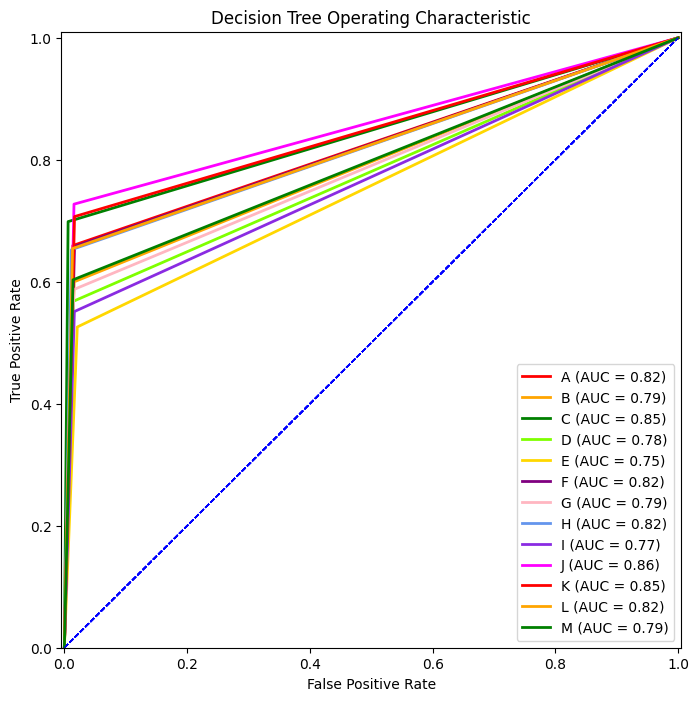

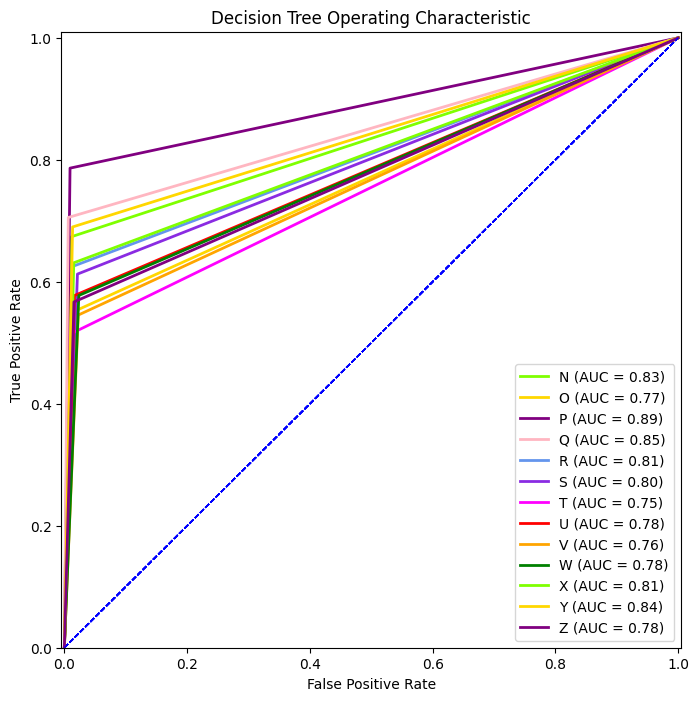

In [27]:
%matplotlib inline

color_list=("red", "orange", "green", "chartreuse", "gold",
            "purple", "lightpink", "cornflowerblue", "blueviolet", "fuchsia")
classes = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 
           'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 
           'W', 'X', 'Y', 'Z']

plt.figure(figsize=(8,8))
total_AUC_dt = 0

for i in range(len(classes)): 
    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_predict_grid_prob_dt[:,i], pos_label=i)
    
    AUC = metrics.auc(fpr, tpr)
    total_AUC_dt += AUC
    plt.plot(fpr, tpr, color=color_list[i%10], lw=2, label=  classes[i] + ' (AUC = %0.2f)' % AUC)

    plt.plot([0, 1], [0, 1], color='blue', lw=1, linestyle='--')

    plt.xlim([-0.005, 1.005])
    plt.ylim([0.0, 1.01])

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Decision Tree Operating Characteristic')
    plt.legend(loc="lower right")

    if i == len(classes)/2 - 1:
      plt.show()
      plt.figure(figsize=(8,8))
        
AUC_average_scores["Decision Tree"] = total_AUC_dt / 26

In [28]:
print("The average AUC for Decision Tree is:", total_AUC_dt / 26)

The average AUC for Decision Tree is: 0.8050470545077903


## Decision Tree Confusion Matrix

In [276]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


data = confusion_matrix(y_test, y_predict_grid_dt)
df_cm = pd.DataFrame(data, columns=np.unique(y_test), index = np.unique(y_test))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'


f, ax = plt.subplots(figsize=(8, 8))
cmap = sns.cubehelix_palette(light=1, as_cmap=True)

sns.heatmap(df_cm, cbar=False, annot=True, cmap=cmap, square=True, fmt='.0f',
            annot_kws={'size': 10})
plt.title('Decision Tree: Actual vs Predicted')
plt.show()

ValueError: Found input variables with inconsistent numbers of samples: [6500, 3250]

## Random Forest

In [30]:
from sklearn.ensemble import RandomForestClassifier

#Instantiates object from the RandomForestClassifier class
my_RandomForest = RandomForestClassifier(n_estimators = 19, bootstrap = True, random_state=1)

#Trains Random Forest Classifier on the training set
my_RandomForest.fit(X_train_new, y_train)

RandomForestClassifier(n_estimators=19, random_state=1)

In [31]:
#Tests Random Forest Classifier on the testing set
y_predict_rf = my_RandomForest.predict(X_test_new)

#Evaluates accuracy of Random Forest Classifier
score_rf = accuracy_score(y_test, y_predict_rf)

print("The accuracy of Random Forest is:",score_rf)

The accuracy of Random Forest is: 0.8221538461538461


## Random Forest Grid Search

In [32]:
from sklearn.ensemble import RandomForestClassifier

#Instantiates object from the SVM class
my_rf = RandomForestClassifier(bootstrap = True, random_state=1)

# defining parameter range
# param_grid_rf = {'n_estimators': [200, 250, 300],
#                  'max_depth': [40]}

param_grid_rf = {'n_estimators': [200, 250, 300],
                 'max_depth': [40, 50, 60]}

  
rf_grid = GridSearchCV(my_rf, param_grid_rf, cv = 5, scoring='accuracy', verbose = 3)

rf_grid.fit(X_train_new, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5] END ....max_depth=40, n_estimators=200;, score=0.855 total time=  23.0s
[CV 2/5] END ....max_depth=40, n_estimators=200;, score=0.866 total time=  22.5s
[CV 3/5] END ....max_depth=40, n_estimators=200;, score=0.878 total time=  22.5s
[CV 4/5] END ....max_depth=40, n_estimators=200;, score=0.878 total time=  22.6s
[CV 5/5] END ....max_depth=40, n_estimators=200;, score=0.861 total time=  22.2s
[CV 1/5] END ....max_depth=40, n_estimators=250;, score=0.862 total time=  28.1s
[CV 2/5] END ....max_depth=40, n_estimators=250;, score=0.872 total time=  27.7s
[CV 3/5] END ....max_depth=40, n_estimators=250;, score=0.877 total time=  28.5s
[CV 4/5] END ....max_depth=40, n_estimators=250;, score=0.882 total time=  28.2s
[CV 5/5] END ....max_depth=40, n_estimators=250;, score=0.864 total time=  29.4s
[CV 1/5] END ....max_depth=40, n_estimators=300;, score=0.866 total time=  33.8s
[CV 2/5] END ....max_depth=40, n_estimators=300;,

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=1),
             param_grid={'max_depth': [40, 50, 60],
                         'n_estimators': [200, 250, 300]},
             scoring='accuracy', verbose=3)

In [33]:
# print best accuracy corresponding to the best structure of model:
print("The best accuracy is:", rf_grid.best_score_)

# print best model paramters 
print("Best parameter value(s):", rf_grid.best_params_)

The best accuracy is: 0.872102564102564
Best parameter value(s): {'max_depth': 40, 'n_estimators': 300}


In [34]:
best_grid_rf = rf_grid.best_estimator_

y_predict_grid_rf = best_grid_rf.predict(X_test_new)
y_predict_grid_prob_rf = best_grid_rf.predict_proba(X_test_new)

score_grid_rf = accuracy_score(y_test, y_predict_grid_rf)

accuracy_scores["Random Forest"] = score_grid_rf
precision_scores ["Random Forest"] = precision_score(y_test, y_predict_grid_rf, average='macro')
recall_scores ["Random Forest"] = metrics.recall_score(y_test, y_predict_grid_rf, average='macro')
f1_scores ["Random Forest"] = metrics.f1_score(y_test, y_predict_grid_rf, average='macro')

print("The accuracy of Random Forest grid is:", score_grid_rf)

The accuracy of Random Forest grid is: 0.8849230769230769


## Random Forest ROC Curve

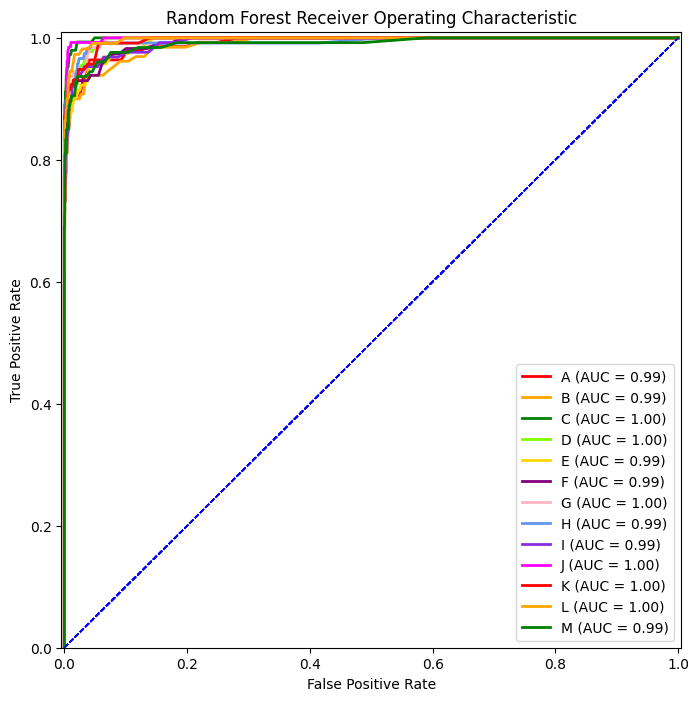

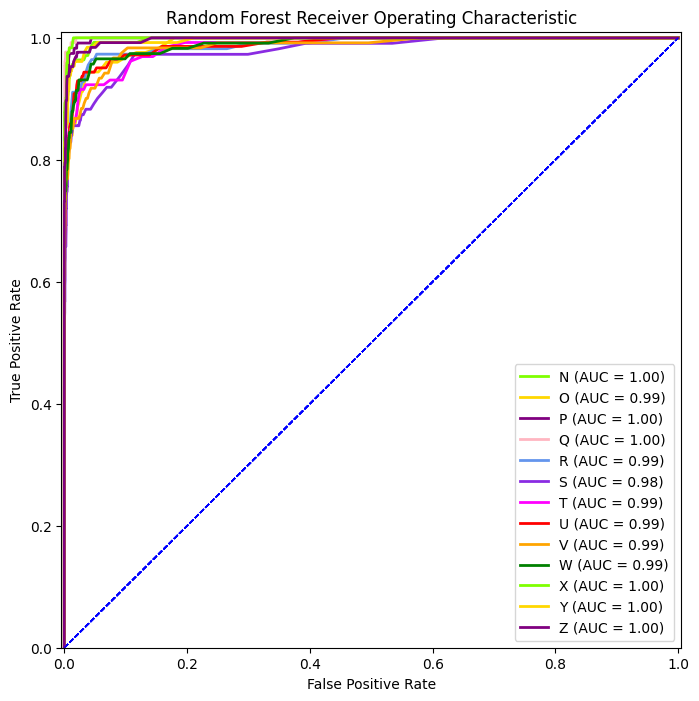

In [35]:
color_list=("red", "orange", "green", "chartreuse", "gold",
            "purple", "lightpink", "cornflowerblue", "blueviolet", "fuchsia")
classes = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 
           'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 
           'W', 'X', 'Y', 'Z']
plt.figure(figsize=(8,8))

total_AUC_rf = 0

for i in range(len(classes)): 
    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_predict_grid_prob_rf[:,i], pos_label=i)
    
    AUC = metrics.auc(fpr, tpr)
    total_AUC_rf += AUC
    plt.plot(fpr, tpr, color=color_list[i%10], lw=2, label=  classes[i] + ' (AUC = %0.2f)' % AUC)

    plt.plot([0, 1], [0, 1], color='blue', lw=1, linestyle='--')

    plt.xlim([-0.005, 1.005])
    plt.ylim([0.0, 1.01])

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Random Forest Receiver Operating Characteristic')
    plt.legend(loc="lower right")

    if i == len(classes)/2 - 1:
      plt.show()
      plt.figure(figsize=(8,8))
        
AUC_average_scores["Random Forest"] = total_AUC_rf / 26

In [36]:
print("The average AUC for Random Forest is:", total_AUC_rf / 26)

The average AUC for Random Forest is: 0.9933329334847383


## Random Forest Confusion Matrix

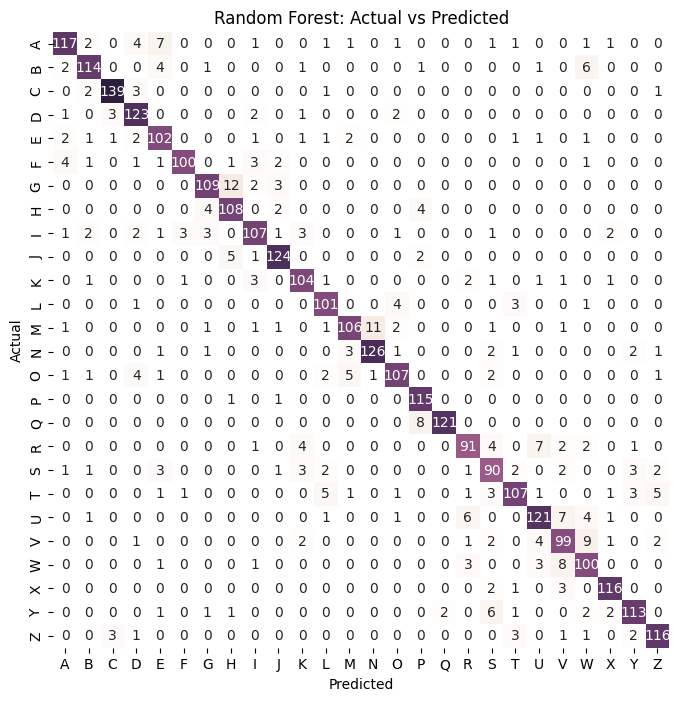

In [37]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


data = confusion_matrix(y_test, y_predict_grid_rf)
df_cm = pd.DataFrame(data, columns=classes, index = classes)
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'


f, ax = plt.subplots(figsize=(8, 8))
cmap = sns.cubehelix_palette(light=1, as_cmap=True)

sns.heatmap(df_cm, cbar=False, annot=True, cmap=cmap, square=True, fmt='.0f',
            annot_kws={'size': 10})
plt.title('Random Forest: Actual vs Predicted')
plt.show()

## KNN

In [38]:
from sklearn.neighbors import KNeighborsClassifier

#Instantiates a KNN object with K=3
k = 3
my_knn = KNeighborsClassifier(n_neighbors = k)

#Trains KNN Classifier on the training set
my_knn.fit(X_train_new, y_train)

KNeighborsClassifier(n_neighbors=3)

In [39]:
#Tests KNN Classifier on the testing set
y_predict_knn = my_knn.predict(X_test_new)

#Evaluates accuracy of KNN Classifier
score_knn = accuracy_score(y_test, y_predict_knn)

print("The accuracy of KNN is:",score_knn)

The accuracy of KNN is: 0.8516923076923076


## KNN Grid Search

In [40]:
from sklearn.neighbors import KNeighborsClassifier

#Instantiates object from the SVM class
my_knn = KNeighborsClassifier()

# defining parameter range
param_grid_knn = {'n_neighbors': [i for i in range(1,20)]} 

  
knn_grid = GridSearchCV(my_knn, param_grid_knn, cv = 5, scoring='accuracy', verbose = 3)

knn_grid.fit(X_train_new, y_train)

Fitting 5 folds for each of 19 candidates, totalling 95 fits
[CV 1/5] END .....................n_neighbors=1;, score=0.894 total time=   0.0s
[CV 2/5] END .....................n_neighbors=1;, score=0.902 total time=   0.0s
[CV 3/5] END .....................n_neighbors=1;, score=0.905 total time=   0.0s
[CV 4/5] END .....................n_neighbors=1;, score=0.901 total time=   0.0s
[CV 5/5] END .....................n_neighbors=1;, score=0.893 total time=   0.0s
[CV 1/5] END .....................n_neighbors=2;, score=0.834 total time=   0.0s
[CV 2/5] END .....................n_neighbors=2;, score=0.844 total time=   0.0s
[CV 3/5] END .....................n_neighbors=2;, score=0.836 total time=   0.0s
[CV 4/5] END .....................n_neighbors=2;, score=0.848 total time=   0.0s
[CV 5/5] END .....................n_neighbors=2;, score=0.835 total time=   0.0s
[CV 1/5] END .....................n_neighbors=3;, score=0.817 total time=   0.0s
[CV 2/5] END .....................n_neighbors=3;

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13, 14, 15, 16, 17, 18, 19]},
             scoring='accuracy', verbose=3)

In [41]:
# print best accuracy corresponding to the best structure of model:
print("The best accuracy is:", knn_grid.best_score_)

# print best model paramters 
print("Best parameter value(s):", knn_grid.best_params_)

The best accuracy is: 0.8988717948717948
Best parameter value(s): {'n_neighbors': 1}


In [42]:
best_grid_knn = knn_grid.best_estimator_

y_predict_grid_knn = best_grid_knn.predict(X_test_new)
y_predict_grid_prob_knn = best_grid_knn.predict_proba(X_test_new)

score_grid_knn = accuracy_score(y_test, y_predict_grid_knn)

accuracy_scores["KNN"] = score_grid_knn
precision_scores ["KNN"] = precision_score(y_test, y_predict_grid_knn, average='macro')
recall_scores ["KNN"] = metrics.recall_score(y_test, y_predict_grid_knn, average='macro')
f1_scores ["KNN"] = metrics.f1_score(y_test, y_predict_grid_knn, average='macro')

print("The accuracy of KNN grid is:", score_grid_knn)

The accuracy of KNN grid is: 0.9138461538461539


## KNN ROC Curve

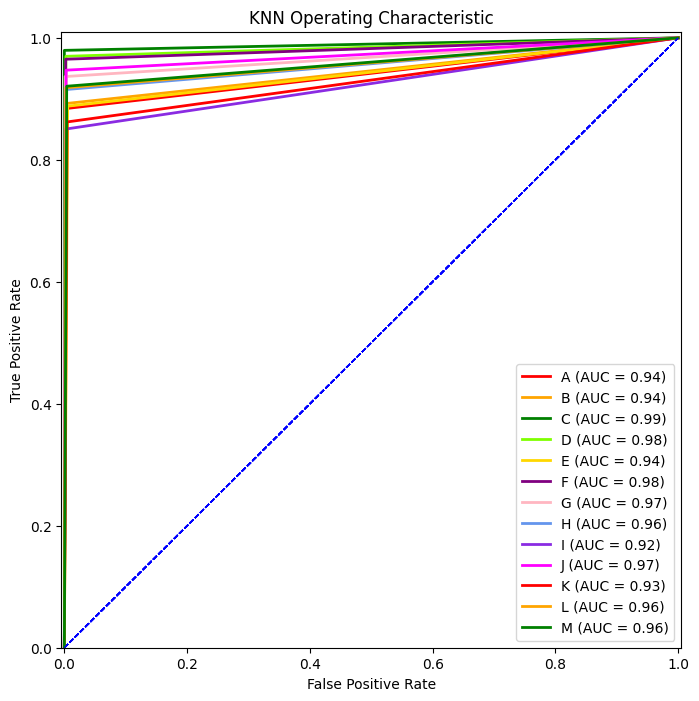

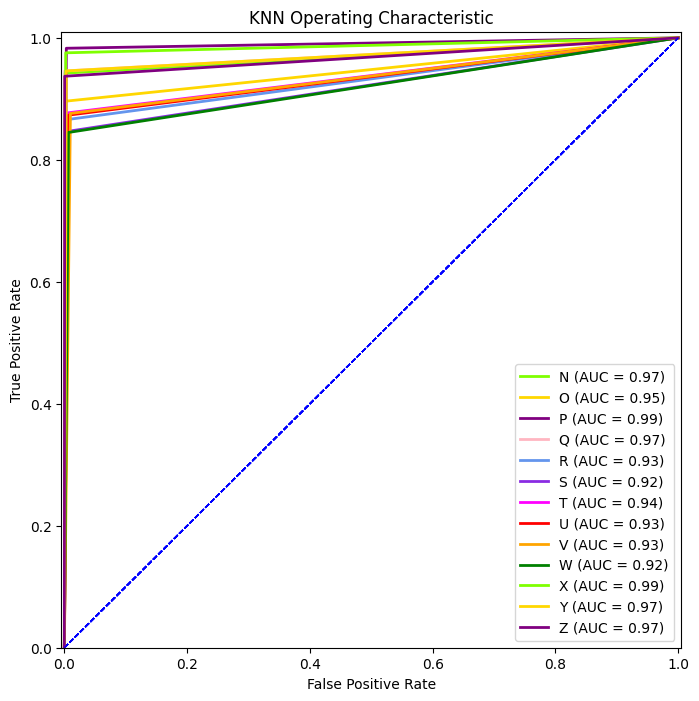

In [43]:
%matplotlib inline

color_list=("red", "orange", "green", "chartreuse", "gold",
            "purple", "lightpink", "cornflowerblue", "blueviolet", "fuchsia")
classes = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 
           'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 
           'W', 'X', 'Y', 'Z']

plt.figure(figsize=(8,8))
total_AUC_knn = 0

for i in range(len(classes)): 
    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_predict_grid_prob_knn[:,i], pos_label=i)
    
    AUC = metrics.auc(fpr, tpr)
    total_AUC_knn += AUC
    plt.plot(fpr, tpr, color=color_list[i%10], lw=2, label=  classes[i] + ' (AUC = %0.2f)' % AUC)

    plt.plot([0, 1], [0, 1], color='blue', lw=1, linestyle='--')

    plt.xlim([-0.005, 1.005])
    plt.ylim([0.0, 1.01])

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('KNN Operating Characteristic')
    plt.legend(loc="lower right")

    if i == len(classes)/2 - 1:
      plt.show()
      plt.figure(figsize=(8,8))
        
AUC_average_scores["KNN"] = total_AUC_knn / 26

In [44]:
print("The average AUC for KNN is:", total_AUC_knn / 26)

The average AUC for KNN is: 0.9547615667231242


## KNN Confusion Matrix

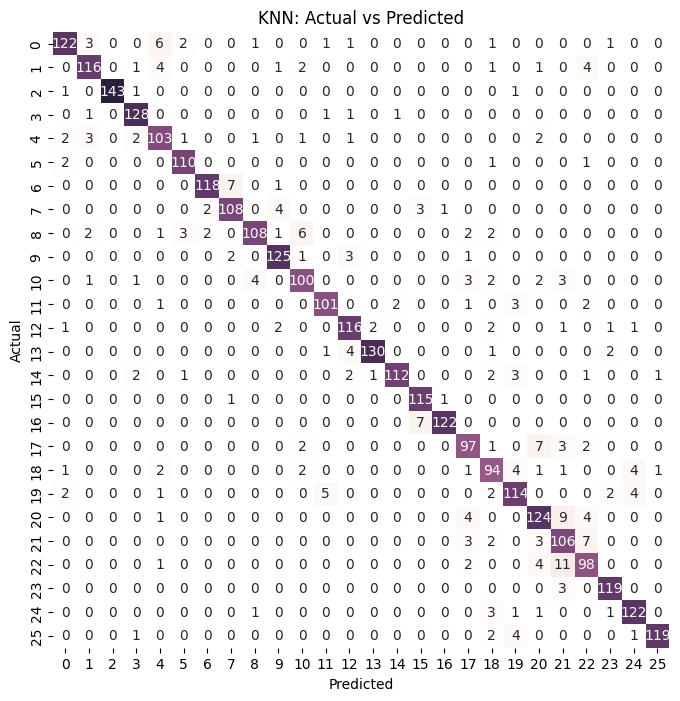

In [45]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


data = confusion_matrix(y_test, y_predict_grid_knn)
df_cm = pd.DataFrame(data, columns=np.unique(y_test), index = np.unique(y_test))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'


f, ax = plt.subplots(figsize=(8, 8))
cmap = sns.cubehelix_palette(light=1, as_cmap=True)

sns.heatmap(df_cm, cbar=False, annot=True, cmap=cmap, square=True, fmt='.0f',
            annot_kws={'size': 10})
plt.title('KNN: Actual vs Predicted')
plt.show()

## XGBoost

In [46]:
from xgboost import XGBClassifier

#Instantiates a XGBoost Object
my_XGBoost = XGBClassifier(n_estimators = 29, random_state = 1)

#Trains XGBoost Classifier on the training set
my_XGBoost.fit(X_train_new, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=29, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

In [47]:
#Tests XGBoost Classifier on the testing set
y_predict_xg = my_XGBoost.predict(X_test_new)

#Evaluates accuracy of XGBoost Classifier
score_xg = accuracy_score(y_test, y_predict_xg)

print("The accuracy of XGBoost is:",score_xg)

The accuracy of XGBoost is: 0.820923076923077


## XGBoost Grid Search

In [48]:
from xgboost import XGBClassifier

#Instantiates object from the SVM class
my_XGBoost = XGBClassifier(random_state = 1)

# defining parameter range
param_grid_xg = {'max_depth': [10, 25, 50],
                 'n_estimators': [40, 70, 10]} 

# param_grid_xg = {'max_depth': [2, 5, 10],
#                  'n_estimators': [20, 30, 40],
#                  'learning_rate': [0.1, 0.01, 0.05]} 

  
xg_grid = GridSearchCV(my_XGBoost, param_grid_xg, cv = 45, scoring='accuracy', verbose = 3)

xg_grid.fit(X_train_new, y_train)

Fitting 45 folds for each of 9 candidates, totalling 405 fits
[CV 1/45] END ....max_depth=10, n_estimators=40;, score=0.889 total time=  37.7s
[CV 2/45] END ....max_depth=10, n_estimators=40;, score=0.788 total time=  37.3s
[CV 3/45] END ....max_depth=10, n_estimators=40;, score=0.857 total time=  37.5s
[CV 4/45] END ....max_depth=10, n_estimators=40;, score=0.829 total time=  37.7s
[CV 5/45] END ....max_depth=10, n_estimators=40;, score=0.843 total time=  37.5s
[CV 6/45] END ....max_depth=10, n_estimators=40;, score=0.811 total time=  34.6s
[CV 7/45] END ....max_depth=10, n_estimators=40;, score=0.839 total time=  34.0s
[CV 8/45] END ....max_depth=10, n_estimators=40;, score=0.816 total time=  34.1s
[CV 9/45] END ....max_depth=10, n_estimators=40;, score=0.880 total time=  33.8s
[CV 10/45] END ...max_depth=10, n_estimators=40;, score=0.853 total time=  33.8s
[CV 11/45] END ...max_depth=10, n_estimators=40;, score=0.871 total time=  34.2s
[CV 12/45] END ...max_depth=10, n_estimators=40

GridSearchCV(cv=45,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=1, ...),
             param_grid={'max_depth': [10, 25, 50],
                         'n_estimators': [40, 70, 10]},
             scoring='accuracy', verbose=3)

In [49]:
# print best accuracy corresponding to the best structure of model:
print("The best accuracy is:", xg_grid.best_score_)

# print best model paramters 
print("Best parameter value(s):", xg_grid.best_params_)

The best accuracy is: 0.8484126984126986
Best parameter value(s): {'max_depth': 10, 'n_estimators': 70}


In [50]:
best_grid_xg = xg_grid.best_estimator_

y_predict_grid_xg = best_grid_xg.predict(X_test_new)
y_predict_grid_prob_xg = best_grid_xg.predict_proba(X_test_new)

score_grid_xg = accuracy_score(y_test, y_predict_grid_xg)

accuracy_scores["XGBoost"] = score_grid_xg
precision_scores ["XGBoost"] = precision_score(y_test, y_predict_grid_xg, average='macro')
recall_scores ["XGBoost"] = metrics.recall_score(y_test, y_predict_grid_xg, average='macro')
f1_scores ["XGBoost"] = metrics.f1_score(y_test, y_predict_grid_xg, average='macro')

print("The accuracy of XGBoost grid is:", score_grid_xg)

The accuracy of XGBoost grid is: 0.8489230769230769


## XGBoost ROC Curve

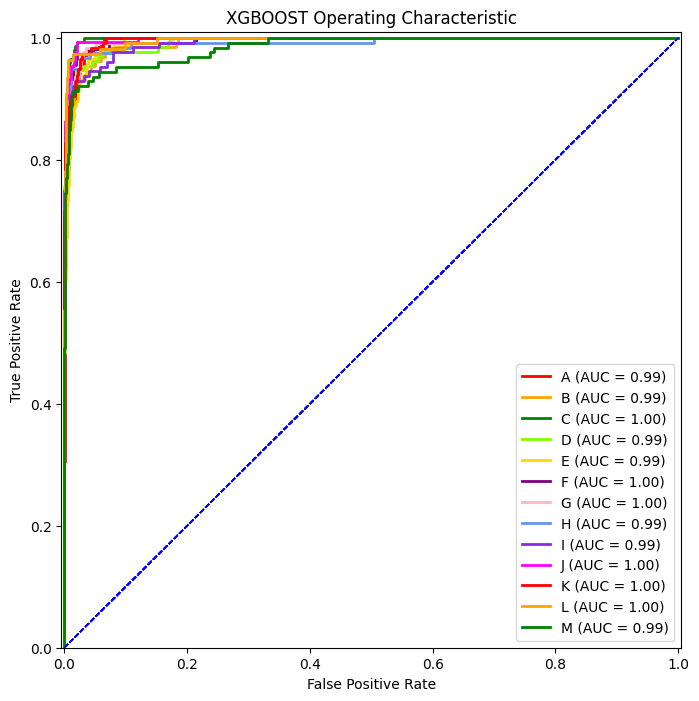

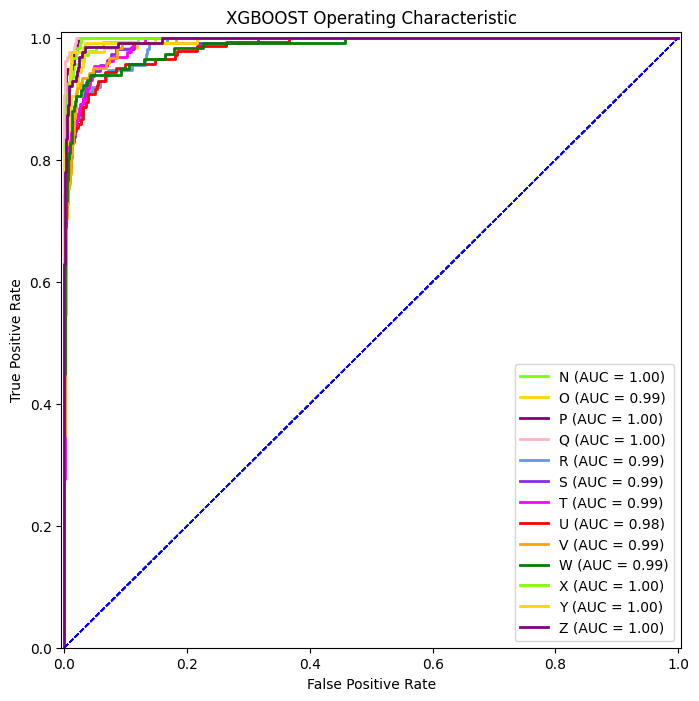

In [51]:
%matplotlib inline

color_list=("red", "orange", "green", "chartreuse", "gold",
            "purple", "lightpink", "cornflowerblue", "blueviolet", "fuchsia")
classes = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 
           'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 
           'W', 'X', 'Y', 'Z']

plt.figure(figsize=(8,8))
total_AUC_xg = 0

for i in range(len(classes)): 
    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_predict_grid_prob_xg[:,i], pos_label=i)
    

    AUC = metrics.auc(fpr, tpr)
    total_AUC_xg += AUC
    plt.plot(fpr, tpr, color=color_list[i%10], lw=2, label=  classes[i] + ' (AUC = %0.2f)' % AUC)

    plt.plot([0, 1], [0, 1], color='blue', lw=1, linestyle='--')

    plt.xlim([-0.005, 1.005])
    plt.ylim([0.0, 1.01])

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('XGBOOST Operating Characteristic')
    plt.legend(loc="lower right")

    if i == len(classes)/2 - 1:
      plt.show()
      plt.figure(figsize=(8,8))
        
AUC_average_scores["XGBoost"] = total_AUC_xg / 26

In [52]:
print("The average AUC for XGBoost is:", total_AUC_xg / 26)

The average AUC for XGBoost is: 0.9935769784927998


## XGBoost Confusion Matrix

In [277]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


data = confusion_matrix(y_test, y_predict_grid_xg)
df_cm = pd.DataFrame(data, columns=np.unique(y_test), index = np.unique(y_test))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'


f, ax = plt.subplots(figsize=(8, 8))
cmap = sns.cubehelix_palette(light=1, as_cmap=True)

sns.heatmap(df_cm, cbar=False, annot=True, cmap=cmap, square=True, fmt='.0f',
            annot_kws={'size': 10})
plt.title('XGBoost: Actual vs Predicted')
plt.show()

ValueError: Found input variables with inconsistent numbers of samples: [6500, 3250]

## AdaBoost

In [54]:
from sklearn.ensemble import AdaBoostClassifier

#Instantiates a AdaBoost Object
my_AdaBoost = AdaBoostClassifier(n_estimators = 29, random_state = 1)

#Trains AdaBoost Classifier on the training set
my_AdaBoost.fit(X_train_new, y_train)

AdaBoostClassifier(n_estimators=29, random_state=1)

In [55]:
#Tests AdaBoost Classifier on the testing set
y_predict_ab = my_AdaBoost.predict(X_test_new)

#Evaluates accuracy of XGBoost Classifier
score_ab = accuracy_score(y_test, y_predict_ab)

print("The accuracy score for AdaBoost is:", score_ab)

The accuracy score for AdaBoost is: 0.132


## AdaBoost Grid Search

In [56]:
from sklearn.ensemble import AdaBoostClassifier

#Instantiates object from the SVM class
my_AdaBoost = AdaBoostClassifier(random_state = 1)

# defining parameter range
param_grid_ab = {'n_estimators': [100, 200],
                 'learning_rate': [0.001, 0.01, .01, 1.0]} 

# # defining parameter range
# param_grid_ab = {'n_estimators': [10, 50, 100, 500],
#                  'learning_rate': [0.0001, 0.001, 0.01, 0.1, 1.0]} 

  
ab_grid = GridSearchCV(my_AdaBoost, param_grid_ab, cv = 5, scoring='accuracy', verbose = 3)

ab_grid.fit(X_train_new, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END learning_rate=0.001, n_estimators=100;, score=0.069 total time=  15.6s
[CV 2/5] END learning_rate=0.001, n_estimators=100;, score=0.067 total time=  15.7s
[CV 3/5] END learning_rate=0.001, n_estimators=100;, score=0.066 total time=  14.5s
[CV 4/5] END learning_rate=0.001, n_estimators=100;, score=0.064 total time=  14.2s
[CV 5/5] END learning_rate=0.001, n_estimators=100;, score=0.068 total time=  14.2s
[CV 1/5] END learning_rate=0.001, n_estimators=200;, score=0.069 total time=  30.1s
[CV 2/5] END learning_rate=0.001, n_estimators=200;, score=0.067 total time=  28.8s
[CV 3/5] END learning_rate=0.001, n_estimators=200;, score=0.066 total time=  28.1s
[CV 4/5] END learning_rate=0.001, n_estimators=200;, score=0.064 total time=  28.6s
[CV 5/5] END learning_rate=0.001, n_estimators=200;, score=0.068 total time=  28.9s
[CV 1/5] END learning_rate=0.01, n_estimators=100;, score=0.111 total time=  14.4s
[CV 2/5] END lear

GridSearchCV(cv=5, estimator=AdaBoostClassifier(random_state=1),
             param_grid={'learning_rate': [0.001, 0.01, 0.01, 1.0],
                         'n_estimators': [100, 200]},
             scoring='accuracy', verbose=3)

In [57]:
# print best accuracy corresponding to the best structure of model:
print("The best accuracy is:", ab_grid.best_score_)

# print best model paramters 
print("Best parameter value(s):", ab_grid.best_params_)

The best accuracy is: 0.14235897435897435
Best parameter value(s): {'learning_rate': 1.0, 'n_estimators': 200}


In [58]:
best_grid_ab = ab_grid.best_estimator_

y_predict_grid_ab = best_grid_ab.predict(X_test_new)
y_predict_grid_prob_ab = best_grid_ab.predict_proba(X_test_new)

score_grid_ab = accuracy_score(y_test, y_predict_grid_ab)

accuracy_scores["AdaBoost"] = score_grid_ab
precision_scores ["AdaBoost"] = precision_score(y_test, y_predict_grid_ab, average='macro')
recall_scores ["AdaBoost"] = metrics.recall_score(y_test, y_predict_grid_ab, average='macro')
f1_scores ["AdaBoost"] = metrics.f1_score(y_test, y_predict_grid_ab, average='macro')

print("The accuracy of AdaBoost grid is:", score_grid_ab)

The accuracy of AdaBoost grid is: 0.17723076923076922


## AdaBoost ROC Curve

In [250]:
y_predict_grid_prob_ab.shape

(3250, 26)

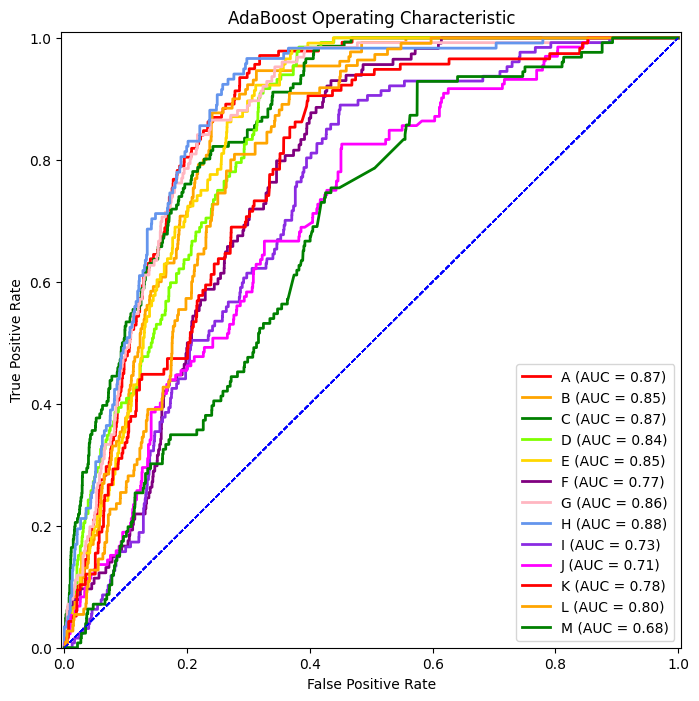

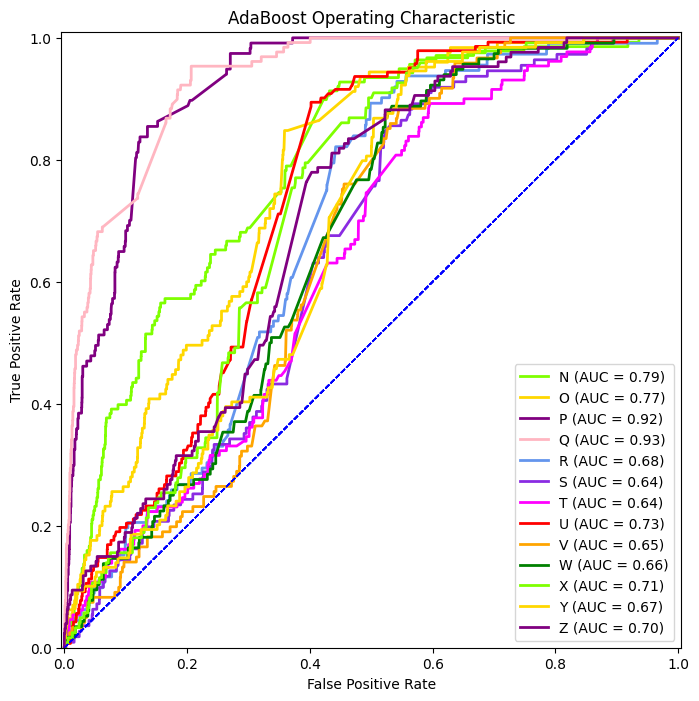

In [59]:
color_list=("red", "orange", "green", "chartreuse", "gold",
            "purple", "lightpink", "cornflowerblue", "blueviolet", "fuchsia")
classes = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 
           'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 
           'W', 'X', 'Y', 'Z']

plt.figure(figsize=(8,8))
total_AUC_ab = 0

for i in range(len(classes)): 
    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_predict_grid_prob_ab[:,i], pos_label=i)

    AUC = metrics.auc(fpr, tpr)
    total_AUC_ab += AUC
    plt.plot(fpr, tpr, color=color_list[i%10], lw=2, label=  classes[i] + ' (AUC = %0.2f)' % AUC)

    plt.plot([0, 1], [0, 1], color='blue', lw=1, linestyle='--')

    plt.xlim([-0.005, 1.005])
    plt.ylim([0.0, 1.01])

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('AdaBoost Operating Characteristic')
    plt.legend(loc="lower right")

    if i == len(classes)/2 - 1:
      plt.show()
      plt.figure(figsize=(8,8))

AUC_average_scores["AdaBoost"] = total_AUC_ab / 26

In [60]:
print("The average AUC for AdaBoost is:", total_AUC_ab / 26)

The average AUC for AdaBoost is: 0.7696346338535615


## AdaBoost Confusion Matrix

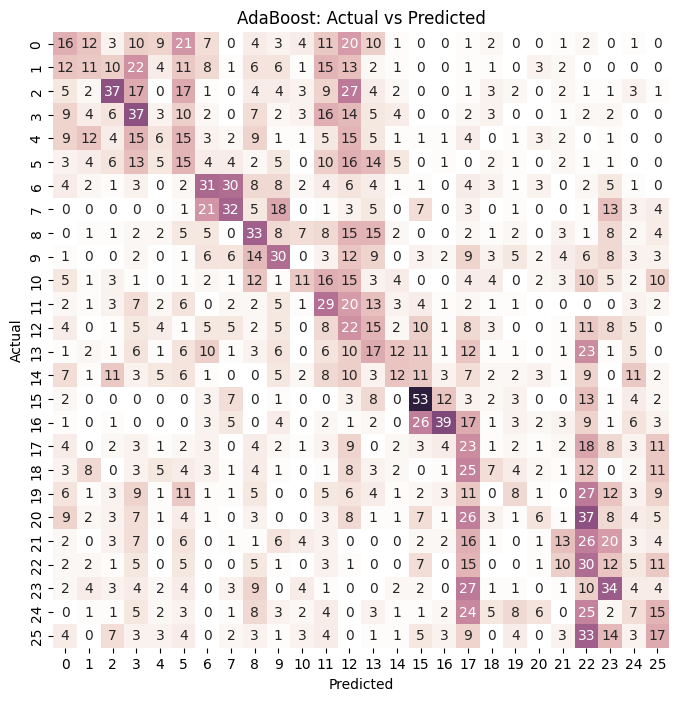

In [61]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


data = confusion_matrix(y_test, y_predict_grid_ab)
df_cm = pd.DataFrame(data, columns=np.unique(y_test), index = np.unique(y_test))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'


f, ax = plt.subplots(figsize=(8, 8))
cmap = sns.cubehelix_palette(light=1, as_cmap=True)

sns.heatmap(df_cm, cbar=False, annot=True, cmap=cmap, square=True, fmt='.0f',
            annot_kws={'size': 10})
plt.title('AdaBoost: Actual vs Predicted')
plt.show()

In [62]:
model_list = ["SVM","Random Forest","Decision Tree","KNN",
             "XGBoost", "AdaBoost"]

accuracy_list = []
precision_list = []
recall_list = []
f1_list = []
AUC_average_list = []

for model in model_list:
    accuracy_list.append(accuracy_scores[model])
    precision_list.append(precision_scores[model])
    recall_list.append(recall_scores[model])
    f1_list.append(f1_scores[model])
    AUC_average_list.append(AUC_average_scores[model])
    

## Model Performance

In [63]:
#prints dataframe of model training results
model_dict = {0: "SVM Classifier", 1: "RandomForest Classifier", 2: "Decision Tree Classifier", 3: "KNNeighbours Classifier",
             4: "XGBoost Classifier", 5: "AdaBoost Classifier"}

performance_df = pd.DataFrame({'Model':model_dict.values(),'Accuracy':accuracy_list,
                               'Precision':precision_list, 'Recall':recall_list,
                               'F1 Score':f1_list, 
                               'Average AUC':AUC_average_list}).sort_values('Accuracy',ascending=False)
performance_df

,Model,Accuracy,Precision,Recall,F1 Score,Average AUC
0,SVM Classifier,0.932308,0.935337,0.931777,0.932688,0.998134
3,KNNeighbours Classifier,0.913846,0.913617,0.912967,0.912816,0.954762
1,RandomForest Classifier,0.884923,0.884531,0.884317,0.883763,0.993333
4,XGBoost Classifier,0.848923,0.849066,0.848924,0.848051,0.993577
2,Decision Tree Classifier,0.625231,0.627962,0.625080,0.624870,0.805047
5,AdaBoost Classifier,0.177231,0.192020,0.178253,0.173277,0.769635


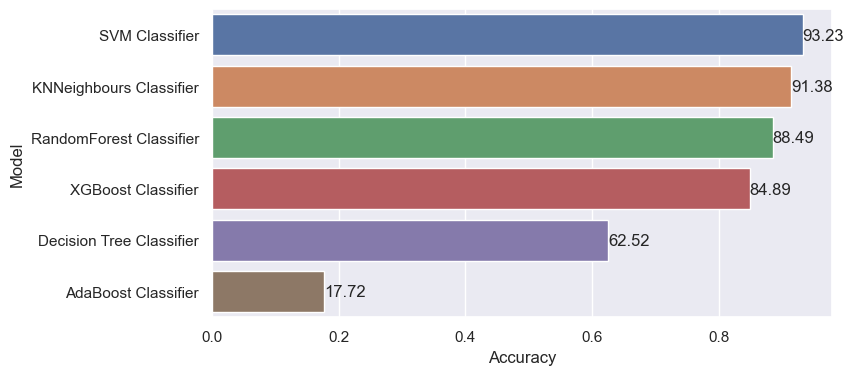

In [64]:
sns.set(rc={'figure.figsize':(8,4)})
ax = sns.barplot(y= 'Model', x='Accuracy', data=performance_df,palette=("deep"))

initialx=0
for p in ax.patches:
  ax.text(p.get_width(),initialx+p.get_height()/8,'{:.2f}'.format(p.get_width()*100))
  initialx+=1

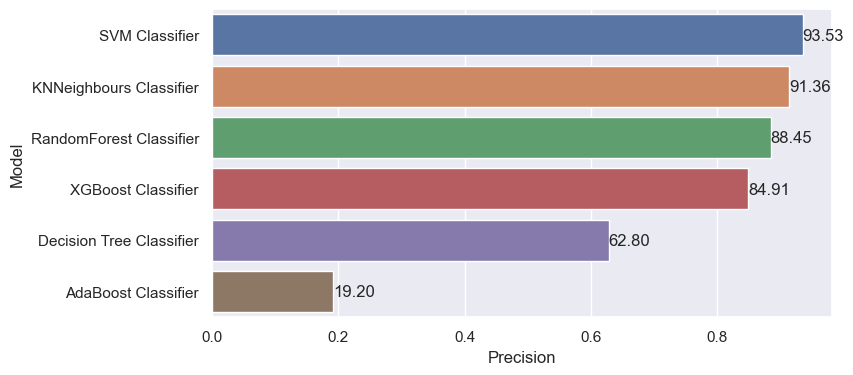

In [65]:
df = performance_df.sort_values('Precision',ascending=False)
sns.set(rc={'figure.figsize':(8,4)})
ax = sns.barplot(y= 'Model', x='Precision', data=df,palette='deep')

initialx=0
for p in ax.patches:
  ax.text(p.get_width(),initialx+p.get_height()/8,'{:.2f}'.format(p.get_width()*100))
  initialx+=1

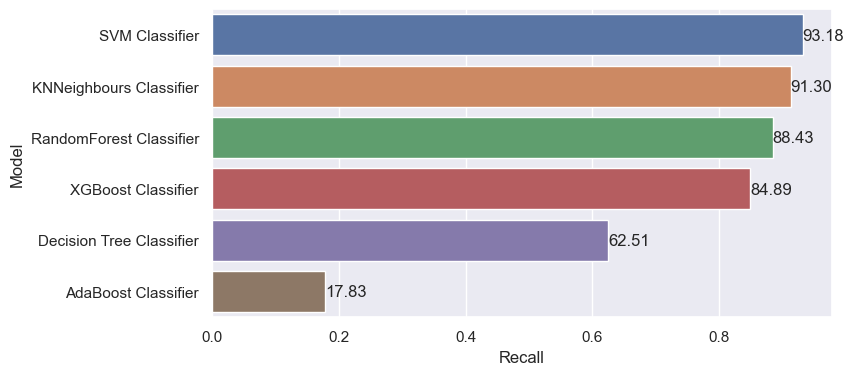

In [66]:
df = performance_df.sort_values('Recall',ascending=False)
sns.set(rc={'figure.figsize':(8,4)})
ax = sns.barplot(y= 'Model', x='Recall', data=df,palette='deep')

initialx=0
for p in ax.patches:
  ax.text(p.get_width(),initialx+p.get_height()/8,'{:.2f}'.format(p.get_width()*100))
  initialx+=1

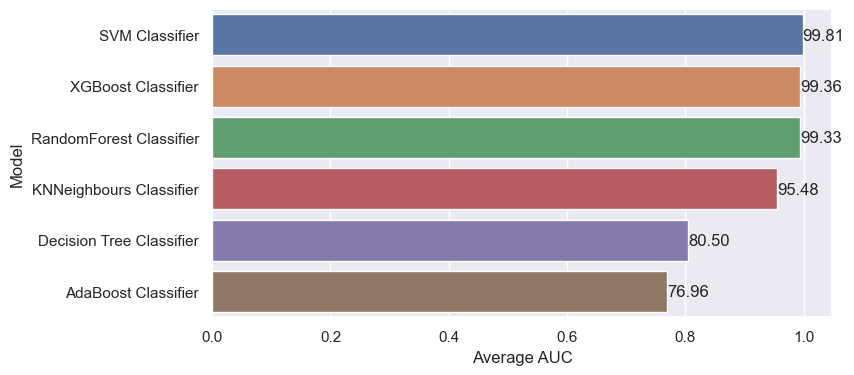

In [67]:
df = performance_df.sort_values('Average AUC',ascending=False)
sns.set(rc={'figure.figsize':(8,4)})
ax = sns.barplot(y= 'Model', x='Average AUC', data=df,palette='deep')

initialx=0
for p in ax.patches:
  ax.text(p.get_width(),initialx+p.get_height()/8,'{:.2f}'.format(p.get_width()*100))
  initialx+=1

# Deep Learning with Convolutional Neural Networks

## Load Data

In [68]:
#directory of folders
train_dir = r"F:\OneDrive - Cal State LA\Lecture Notes\Spring 2023\Machine Learning 2\ML2 Project\asl_alphabet_train"

classes = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 
           'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 
           'W', 'X', 'Y', 'Z']

In [126]:
import random

#specify the number of samples desired for each label
number_of_samples = 1000

#create a random sample of ints from 0 to 3000 without repetition
rand_list = random.sample(range(3001), number_of_samples)

#specify desired dimension of the images
imageSize = 50

#create np array to serve as feature matrix
X = np.empty((number_of_samples * 26, imageSize, imageSize, 3), dtype=np.float32)

#adds image label to label array
y = []

index = 0
for letter in classes:
    print("loading class:", letter)
    #X_temp = []
    for x in rand_list:
        #reads image from directory
        image = mpimg.imread(train_dir + "\\" + letter + "\\"+ letter + str(x) + ".jpg")
        
        #Resize image to imageSize x imageSize pixels
        image = skimage.transform.resize(image, (imageSize, imageSize, 3))
        
        #convert each image into a row of the feature matrix with imageSize * imageSize * 3 columns
        image = np.asarray(image).reshape((-1, imageSize, imageSize, 3))
        
        X[index] = image
        y.append(ord(letter)-65)
        index +=1

loading class: A
loading class: B
loading class: C
loading class: D
loading class: E
loading class: F
loading class: G
loading class: H
loading class: I
loading class: J
loading class: K
loading class: L
loading class: M
loading class: N
loading class: O
loading class: P
loading class: Q
loading class: R
loading class: S
loading class: T
loading class: U
loading class: V
loading class: W
loading class: X
loading class: Y
loading class: Z


In [127]:
#Randomly splits the original dataset into training set and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=5)

del X

In [128]:
X_train.shape

(19500, 50, 50, 3)

In [129]:
X_test.shape

(6500, 50, 50, 3)

In [130]:
from tensorflow.keras.utils import to_categorical

# One-Hot-Encoding the categorical data
y_train_cat = to_categorical(y_train,26)
y_test_cat = to_categorical(y_test,26)

## Shallow CNN Building and Training

In [150]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Activation, Dense, Flatten

In [151]:
model = Sequential()

#convolutional layer
model.add(Conv2D(32, (5, 5), input_shape=(imageSize, imageSize, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D((2, 2)))

#flatten output of convolutional layer
model.add(Flatten())

#hidden layer
model.add(Dense(2 * imageSize, activation='relu'))

#output layer
model.add(Dense(26, activation='softmax'))

model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_11 (Conv2D)          (None, 46, 46, 32)        2432      
                                                                 
 activation_4 (Activation)   (None, 46, 46, 32)        0         
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 23, 23, 32)       0         
 2D)                                                             
                                                                 
 flatten_7 (Flatten)         (None, 16928)             0         
                                                                 
 dense_14 (Dense)            (None, 100)               1692900   
                                                                 
 dense_15 (Dense)            (None, 26)                2626      
                                                      

In [152]:
from tensorflow.keras.callbacks import EarlyStopping

#implement early stop to ensure model fitting stops before overfitting
early_stop = EarlyStopping(monitor='val_loss',patience=2)

In [153]:
#compile the sequential model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [154]:
#train the sequential model
model.fit(X_train, y_train_cat,
          epochs=50,
          batch_size=64,
          verbose=2,
          validation_data=(X_test, y_test_cat),
         callbacks=[early_stop])

Epoch 1/50
305/305 - 15s - loss: 2.4387 - accuracy: 0.2820 - val_loss: 1.7388 - val_accuracy: 0.4635 - 15s/epoch - 49ms/step
Epoch 2/50
305/305 - 16s - loss: 1.2956 - accuracy: 0.6062 - val_loss: 1.0139 - val_accuracy: 0.6897 - 16s/epoch - 51ms/step
Epoch 3/50
305/305 - 15s - loss: 0.7846 - accuracy: 0.7624 - val_loss: 0.7591 - val_accuracy: 0.7595 - 15s/epoch - 49ms/step
Epoch 4/50
305/305 - 14s - loss: 0.5233 - accuracy: 0.8476 - val_loss: 0.5227 - val_accuracy: 0.8428 - 14s/epoch - 46ms/step
Epoch 5/50
305/305 - 15s - loss: 0.3638 - accuracy: 0.8950 - val_loss: 0.4284 - val_accuracy: 0.8685 - 15s/epoch - 48ms/step
Epoch 6/50
305/305 - 15s - loss: 0.2717 - accuracy: 0.9236 - val_loss: 0.3660 - val_accuracy: 0.8886 - 15s/epoch - 49ms/step
Epoch 7/50
305/305 - 15s - loss: 0.2029 - accuracy: 0.9426 - val_loss: 0.3278 - val_accuracy: 0.8966 - 15s/epoch - 48ms/step
Epoch 8/50
305/305 - 14s - loss: 0.1582 - accuracy: 0.9562 - val_loss: 0.2810 - val_accuracy: 0.9182 - 14s/epoch - 46ms/step


In [155]:
#display model metrics
metrics = pd.DataFrame(model.history.history)
print("The metrics of the CNN are:")
metrics

The metrics of the CNN are:


,loss,accuracy,val_loss,val_accuracy
0,2.438706,0.282000,1.738781,0.463538
1,1.295612,0.606154,1.013916,0.689692
2,0.784593,0.762410,0.759089,0.759538
3,0.523271,0.847590,0.522705,0.842769
4,0.363757,0.895026,0.428420,0.868462
5,0.271710,0.923641,0.366013,0.888615
6,0.202860,0.942564,0.327762,0.896615
7,0.158214,0.956205,0.281041,0.918154
8,0.128280,0.964923,0.306551,0.907385
9,0.104221,0.973949,0.298702,0.911538


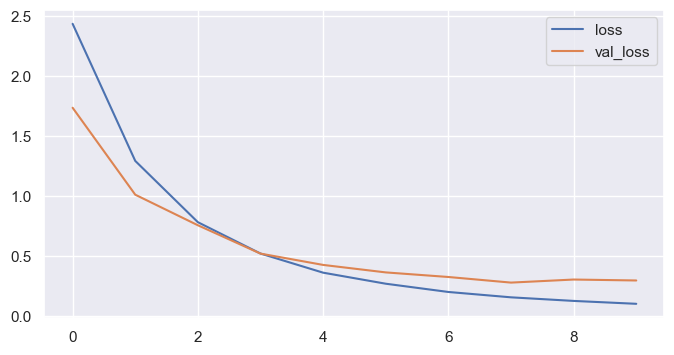

In [156]:
#plot training loss
metrics[['loss','val_loss']].plot()
plt.show()

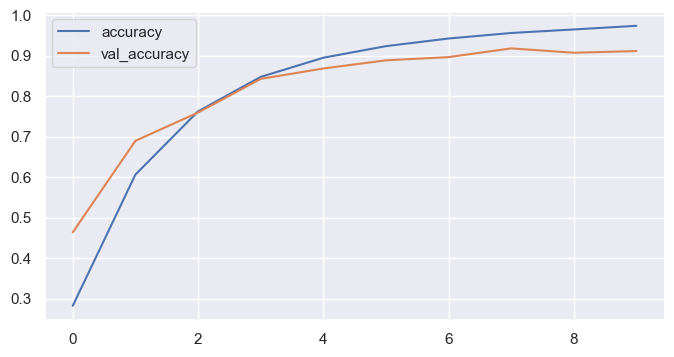

In [157]:
#plot testing loss
metrics[['accuracy','val_accuracy']].plot()
plt.show()

In [158]:
model.evaluate(X_test,y_test_cat,verbose=0)

[0.29870209097862244, 0.9115384817123413]

## Deep CNN Building and Training

In [159]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Activation, Dense, Flatten

In [180]:
model_deep = Sequential()

#convolutional layer
model_deep.add(Conv2D(32, (5, 5), activation='relu', input_shape=(imageSize, imageSize, 3),padding="same"))
model_deep.add(Conv2D(32, (5, 5),activation='relu', padding="same"))

#pooling layer
model_deep.add(MaxPooling2D((2, 2)))

#Dropout layer to avoid overfitting
model_deep.add(Dropout(0.25)) 

#flatten output of convolutional layer
model_deep.add(Flatten())

#hidden layer
model_deep.add(Dense(128, activation='relu'))
model_deep.add(Dropout(0.25))

#output layer
model_deep.add(Dense(26, activation='softmax'))

model_deep.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 50, 50, 32)        2432      
                                                                 
 conv2d_17 (Conv2D)          (None, 50, 50, 32)        25632     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 25, 25, 32)       0         
 g2D)                                                            
                                                                 
 dropout_12 (Dropout)        (None, 25, 25, 32)        0         
                                                                 
 flatten_10 (Flatten)        (None, 20000)             0         
                                                                 
 dense_20 (Dense)            (None, 128)               2560128   
                                                     

In [181]:
from tensorflow.keras.callbacks import EarlyStopping

#implement early stop to ensure model fitting stops before overfitting
early_stop = EarlyStopping(monitor='val_loss',patience=2)

In [182]:
#compile the sequential model
model_deep.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [183]:
#train the sequential model
model_deep.fit(X_train, y_train_cat,
          epochs=50,
          batch_size=64,
          verbose=2,
          validation_data=(X_test, y_test_cat),
         callbacks=[early_stop])

Epoch 1/50
305/305 - 88s - loss: 2.3166 - accuracy: 0.3044 - val_loss: 1.2080 - val_accuracy: 0.6435 - 88s/epoch - 288ms/step
Epoch 2/50
305/305 - 89s - loss: 1.0694 - accuracy: 0.6466 - val_loss: 0.6412 - val_accuracy: 0.7991 - 89s/epoch - 291ms/step
Epoch 3/50
305/305 - 82s - loss: 0.6949 - accuracy: 0.7651 - val_loss: 0.4362 - val_accuracy: 0.8749 - 82s/epoch - 270ms/step
Epoch 4/50
305/305 - 85s - loss: 0.5119 - accuracy: 0.8239 - val_loss: 0.3136 - val_accuracy: 0.8997 - 85s/epoch - 280ms/step
Epoch 5/50
305/305 - 81s - loss: 0.4007 - accuracy: 0.8636 - val_loss: 0.2626 - val_accuracy: 0.9135 - 81s/epoch - 267ms/step
Epoch 6/50
305/305 - 77s - loss: 0.3276 - accuracy: 0.8851 - val_loss: 0.2122 - val_accuracy: 0.9334 - 77s/epoch - 253ms/step
Epoch 7/50
305/305 - 81s - loss: 0.2835 - accuracy: 0.9011 - val_loss: 0.1840 - val_accuracy: 0.9414 - 81s/epoch - 266ms/step
Epoch 8/50
305/305 - 82s - loss: 0.2342 - accuracy: 0.9177 - val_loss: 0.1618 - val_accuracy: 0.9480 - 82s/epoch - 270

In [186]:
#display model metrics
metrics_deep = pd.DataFrame(model_deep.history.history)
print("The metrics of the CNN are:")
metrics_deep

The metrics of the CNN are:


,loss,accuracy,val_loss,val_accuracy
0,2.316554,0.304359,1.207958,0.643538
1,1.069428,0.646615,0.641183,0.799077
2,0.694865,0.765128,0.436241,0.874923
3,0.511937,0.823949,0.313556,0.899692
4,0.400729,0.863590,0.262610,0.913538
5,0.327631,0.885077,0.212177,0.933385
6,0.283514,0.901077,0.184035,0.941385
7,0.234164,0.917744,0.161775,0.948000
8,0.218343,0.924051,0.133513,0.961077
9,0.183896,0.936103,0.145797,0.952000


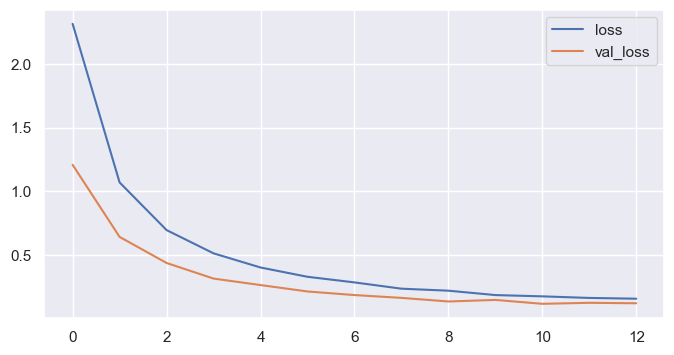

In [187]:
#plot training loss
metrics_deep[['loss','val_loss']].plot()
plt.show()

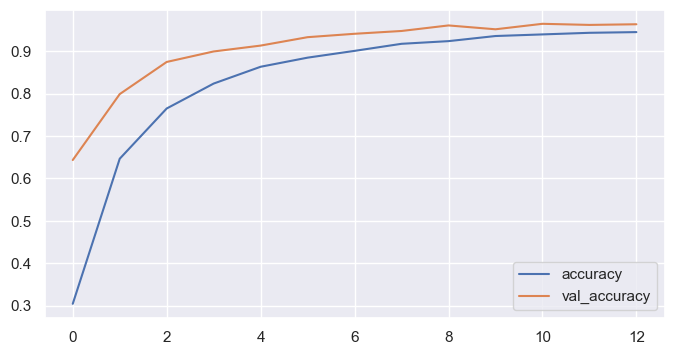

In [188]:
#plot testing loss
metrics_deep[['accuracy','val_accuracy']].plot()
plt.show()

In [189]:
model_deep.evaluate(X_test,y_test_cat,verbose=0)

[0.119508758187294, 0.9638461470603943]

In [192]:
predicted_classes_deep = model_deep.predict(X_test)

# Testing:
score_deep = model_deep.evaluate(X_test, y_test_cat, verbose=1)
print('The accuracy is: ', score_deep[1])

204/204 [==============================] - 5s 23ms/step - loss: 0.1195 - accuracy: 0.9638
The accuracy is:  0.9638461470603943


In [256]:
y_predict_deep_cnn = model_deep.predict(X_test)

204/204 [==============================] - 5s 23ms/step


In [253]:
from sklearn.metrics import classification_report


y_predict_deep_cnn2 = model_deep.predict(X_test) 
y_predict_deep_cnn2 = np.argmax(y_predict_deep_cnn2, axis=1)
y_test2 = np.argmax(y_test_cat, axis=1)
class_report = classification_report(y_test2, y_predict_deep_cnn2)
print(class_report)

204/204 [==============================] - 5s 23ms/step
              precision    recall  f1-score   support

           0       0.95      0.95      0.95       268
           1       0.95      0.97      0.96       258
           2       1.00      1.00      1.00       251
           3       0.99      0.97      0.98       227
           4       0.95      0.93      0.94       244
           5       0.99      0.98      0.99       254
           6       0.98      0.97      0.98       269
           7       0.97      0.98      0.98       255
           8       0.99      0.97      0.98       248
           9       1.00      0.98      0.99       234
          10       0.99      0.98      0.98       239
          11       0.98      0.99      0.99       241
          12       0.92      0.98      0.95       250
          13       1.00      0.91      0.95       225
          14       0.97      0.99      0.98       242
          15       0.98      0.99      0.99       244
          16       1.00  

In [255]:
accuracy_scores["CNN"] = score_deep[1]
precision_scores ["CNN"] = precision_score(y_test2, y_predict_deep_cnn2, average='macro')
recall_scores ["CNN"] = metrics.recall_score(y_test2, y_predict_deep_cnn2, average='macro')
f1_scores ["CNN"] = metrics.f1_score(y_test2, y_predict_deep_cnn2, average='macro')

print("The accuracy of CNN grid is:", score_deep[1])

The accuracy of CNN grid is: 0.9638461470603943


## CNN ROC Curve

In [273]:
auc_roc = roc_auc_score(y_test_cat,model_deep.predict(X_test), multi_class='ovr')
print(auc_roc)

204/204 [==============================] - 5s 23ms/step
0.9995762687436558


In [246]:
y_test_list = list(y_test2)

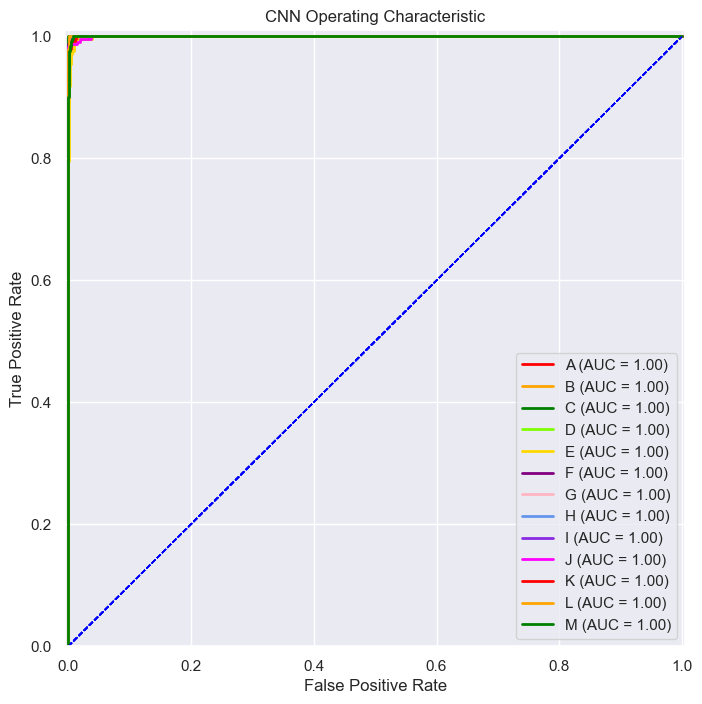

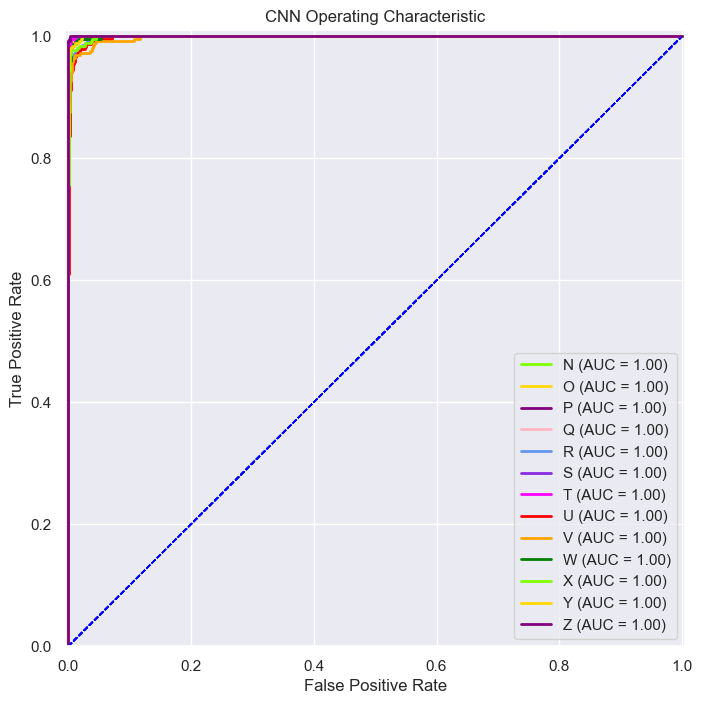

In [262]:
color_list=("red", "orange", "green", "chartreuse", "gold",
            "purple", "lightpink", "cornflowerblue", "blueviolet", "fuchsia")
classes = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 
           'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 
           'W', 'X', 'Y', 'Z']

plt.figure(figsize=(8,8))
total_AUC_cnn = 0

for i in range(len(classes)): 
    fpr, tpr, thresholds = metrics.roc_curve(y_test_list, y_predict_deep_cnn[:,i], pos_label=i)

    AUC = metrics.auc(fpr, tpr)
    total_AUC_cnn += AUC
    plt.plot(fpr, tpr, color=color_list[i%10], lw=2, label=  classes[i] + ' (AUC = %0.2f)' % AUC)

    plt.plot([0, 1], [0, 1], color='blue', lw=1, linestyle='--')

    plt.xlim([-0.005, 1.005])
    plt.ylim([0.0, 1.01])

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('CNN Operating Characteristic')
    plt.legend(loc="lower right")

    if i == len(classes)/2 - 1:
      plt.show()
      plt.figure(figsize=(8,8))

AUC_average_scores["CNN"] = total_AUC_cnn / 26

In [279]:
print("The average AUC for CNN is:", total_AUC_cnn / 26)

The average AUC for CNN is: 0.9995762687436556


## CNN Confusion Matrix

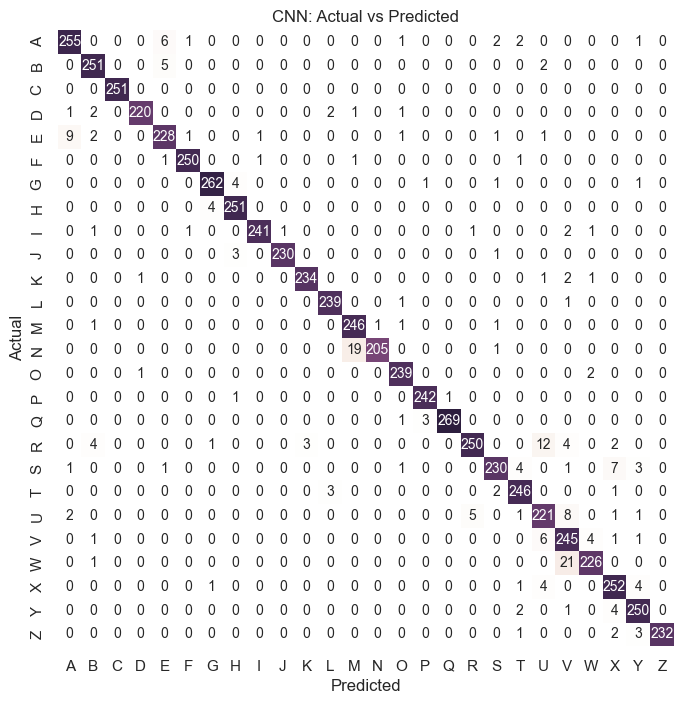

In [278]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#y_test2, y_predict_deep_cnn2
data = confusion_matrix(y_test2, y_predict_deep_cnn2)
df_cm = pd.DataFrame(data, columns=classes, index = classes)
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'


f, ax = plt.subplots(figsize=(8, 8))
cmap = sns.cubehelix_palette(light=1, as_cmap=True)

sns.heatmap(df_cm, cbar=False, annot=True, cmap=cmap, square=True, fmt='.0f',
            annot_kws={'size': 10})
plt.title('CNN: Actual vs Predicted')
plt.show()

## Model Performance

In [264]:
model_list = ["SVM","Random Forest","Decision Tree","KNN",
             "XGBoost", "AdaBoost", "CNN"]

accuracy_list = []
precision_list = []
recall_list = []
f1_list = []
AUC_average_list = []

for model in model_list:
    accuracy_list.append(accuracy_scores[model])
    precision_list.append(precision_scores[model])
    recall_list.append(recall_scores[model])
    f1_list.append(f1_scores[model])
    AUC_average_list.append(AUC_average_scores[model])

In [267]:
#prints dataframe of model training results
model_dict = {0: "SVM Classifier", 1: "RandomForest Classifier", 2: "Decision Tree Classifier", 3: "KNNeighbours Classifier",
             4: "XGBoost Classifier", 5: "AdaBoost Classifier", 6:"Convolutional Neural Network"}

performance_df = pd.DataFrame({'Model':model_dict.values(),'Accuracy':accuracy_list,
                               'Precision':precision_list, 'Recall':recall_list,
                               'F1 Score':f1_list, 
                               'Average AUC':AUC_average_list}).sort_values('Accuracy',ascending=False)
performance_df

,Model,Accuracy,Precision,Recall,F1 Score,Average AUC
6,Convolutional Neural Network,0.963846,0.965117,0.963854,0.964135,0.999576
0,SVM Classifier,0.932308,0.935337,0.931777,0.932688,0.998134
3,KNNeighbours Classifier,0.913846,0.913617,0.912967,0.912816,0.954762
1,RandomForest Classifier,0.884923,0.884531,0.884317,0.883763,0.993333
4,XGBoost Classifier,0.848923,0.849066,0.848924,0.848051,0.993577
2,Decision Tree Classifier,0.625231,0.627962,0.625080,0.624870,0.805047
5,AdaBoost Classifier,0.177231,0.192020,0.178253,0.173277,0.769635


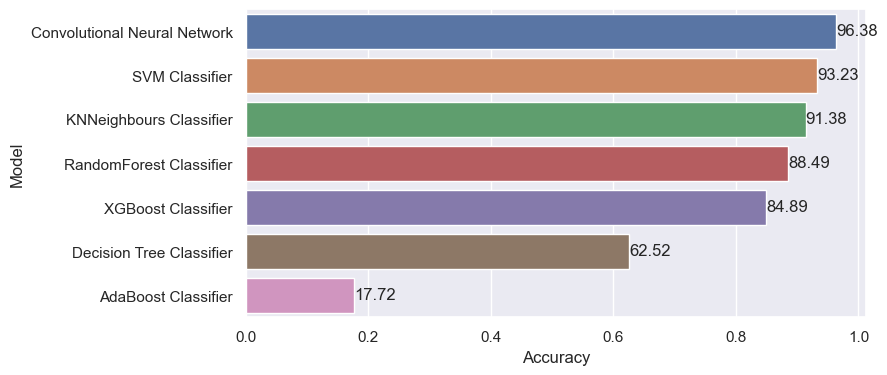

In [268]:
sns.set(rc={'figure.figsize':(8,4)})
ax = sns.barplot(y= 'Model', x='Accuracy', data=performance_df,palette=("deep"))

initialx=0
for p in ax.patches:
  ax.text(p.get_width(),initialx+p.get_height()/8,'{:.2f}'.format(p.get_width()*100))
  initialx+=1

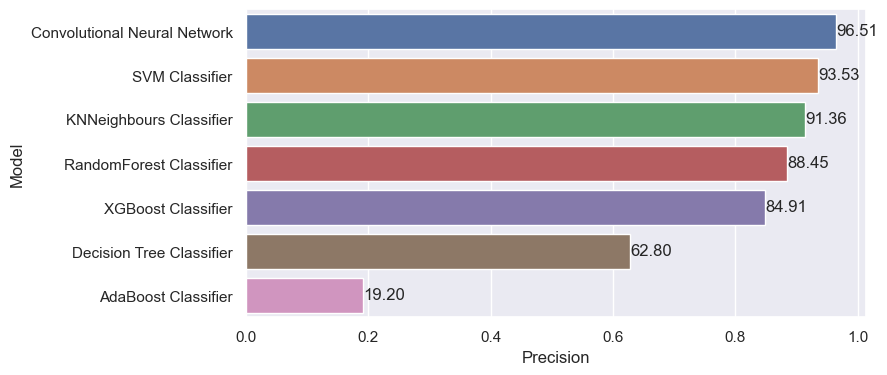

In [269]:
df = performance_df.sort_values('Precision',ascending=False)
sns.set(rc={'figure.figsize':(8,4)})
ax = sns.barplot(y= 'Model', x='Precision', data=df,palette='deep')

initialx=0
for p in ax.patches:
  ax.text(p.get_width(),initialx+p.get_height()/8,'{:.2f}'.format(p.get_width()*100))
  initialx+=1

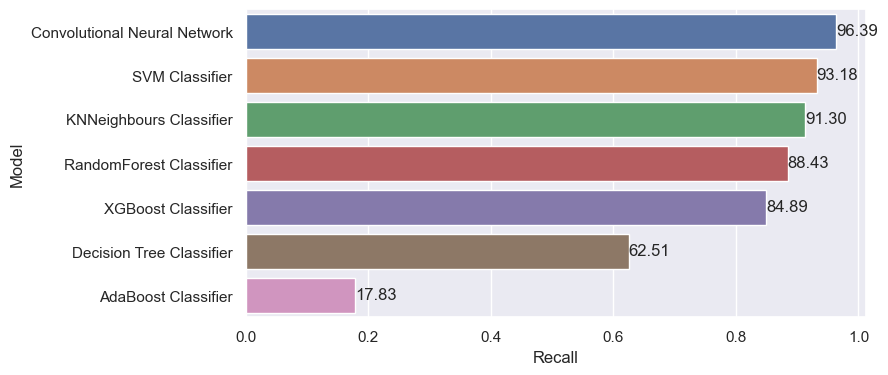

In [270]:
df = performance_df.sort_values('Recall',ascending=False)
sns.set(rc={'figure.figsize':(8,4)})
ax = sns.barplot(y= 'Model', x='Recall', data=df,palette='deep')

initialx=0
for p in ax.patches:
  ax.text(p.get_width(),initialx+p.get_height()/8,'{:.2f}'.format(p.get_width()*100))
  initialx+=1

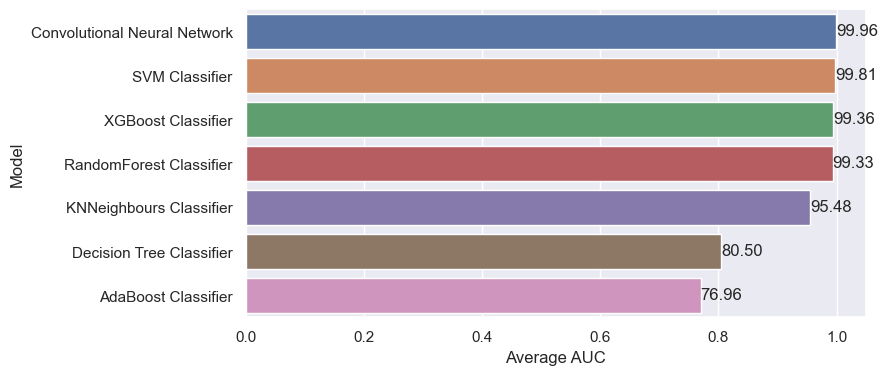

In [271]:
df = performance_df.sort_values('Average AUC',ascending=False)
sns.set(rc={'figure.figsize':(8,4)})
ax = sns.barplot(y= 'Model', x='Average AUC', data=df,palette='deep')

initialx=0
for p in ax.patches:
  ax.text(p.get_width(),initialx+p.get_height()/8,'{:.2f}'.format(p.get_width()*100))
  initialx+=1